**Upload 5 Data Class**

In [1]:
from google.colab import files
uploaded = files.upload()
!unzip Dataset.zip

Saving Dataset.zip to Dataset.zip
Archive:  Dataset.zip
replace Dataset/Class 1/0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Dataset/Class 1/0.png   
  inflating: Dataset/Class 1/1.png   
  inflating: Dataset/Class 1/10.png  
  inflating: Dataset/Class 1/100.png  
  inflating: Dataset/Class 1/101.png  
  inflating: Dataset/Class 1/102.png  
  inflating: Dataset/Class 1/103.png  
  inflating: Dataset/Class 1/104.png  
  inflating: Dataset/Class 1/105.png  
  inflating: Dataset/Class 1/106.png  
  inflating: Dataset/Class 1/107.png  
  inflating: Dataset/Class 1/108.png  
  inflating: Dataset/Class 1/109.png  
  inflating: Dataset/Class 1/11.png  
  inflating: Dataset/Class 1/110.png  
  inflating: Dataset/Class 1/111.png  
  inflating: Dataset/Class 1/112.png  
  inflating: Dataset/Class 1/113.png  
  inflating: Dataset/Class 1/114.png  
  inflating: Dataset/Class 1/115.png  
  inflating: Dataset/Class 1/116.png  
  inflating: Dataset/Class 1/117.png  
  inflating: Datase

Import Libraries

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

!pip install torchmetrics
from torchmetrics.classification import BinaryAccuracy

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import os

from tqdm import tqdm_notebook as tqdm
import tqdm
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Create Transforms, Datasets and, DataLoader

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, ), std=(0.5, )),
    transforms.Grayscale(num_output_channels=1)
])

dataset = torchvision.datasets.ImageFolder(
    root='/content/Dataset',
    transform=transform
)

dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=128,
    shuffle=True
)

Plot Image Function

In [3]:
def plot_image(image_tensor, num_images=25, size=(1, 32, 32)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Create Device

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

Initialize Weights

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Create Noise in Image

In [6]:
def get_noise(samples_num, dimention):
    return torch.randn(samples_num, dimention, device=device)

Create Generator

In [7]:
Generator = nn.Sequential(
    # Input Size is 133.
    nn.ConvTranspose2d(133, 512, (4, 4), (1, 1), (0, 0), bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # CONV1 Size is 521*4*4.
    nn.ConvTranspose2d(512, 256, (4, 4), (2, 2), (1, 1), bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # CONV2 Size is 256*8*8.
    nn.ConvTranspose2d(256, 128, (4, 4), (2, 2), (1, 1), bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # CONV3 Size is 128*16*16.
    nn.ConvTranspose2d(128, 64, (4, 4), (2, 2), (1, 1), bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # CONV4 Size is 64*32*32.
    nn.ConvTranspose2d(64, 1, (4, 4), (2, 2), (1, 1), bias=False),
    nn.Tanh()
    # Output Size is 1*64*64.
)

G = Generator.to(device)
G.apply(weights_init)

Create Discriminator

In [8]:
Discriminator = nn.Sequential(
    # Input Size is 1*64*64.
    nn.Conv2d(1, 64, (4, 4), (2, 2), (1, 1), bias=False),
    nn.LeakyReLU(0.2, True),
    # CONV1 Size is 64*32*32.
    nn.Conv2d(64, 128, (4, 4), (2, 2), (1, 1), bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, True),
    # CONV2 Size is 128*16*16.
    nn.Conv2d(128, 256, (4, 4), (2, 2), (1, 1), bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, True),
    # CONV3 Size is 256*8*8.
    nn.Conv2d(256, 512, (4, 4), (2, 2), (1, 1), bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, True),
    # CONV4 Size is 512*4*4.
    nn.Conv2d(512, 1, (4, 4), (1, 1), (0, 0), bias=False),
    # nn.Sigmoid()
    nn.LeakyReLU(0.2, True)
    # Output Size is 1.
    )

D = Discriminator.to(device)

Create Optimizer for Generator and Discriminator and Loss Function

In [9]:
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCEWithLogitsLoss()
Accuracy = BinaryAccuracy().to(device)

Train Model

Epoch 12:   Accuracy = 1.953125%   Generator Loss = 1.2036273863911624   Discriminator Loss = 0.598287741243839


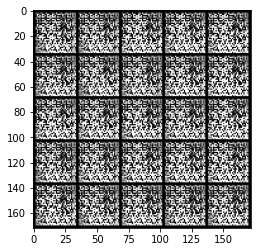

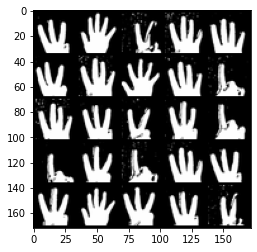

Epoch 25:   Accuracy = 3.90625%   Generator Loss = 2.3070767831802375   Discriminator Loss = 0.24287184789776814


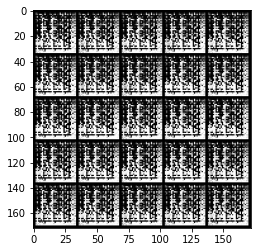

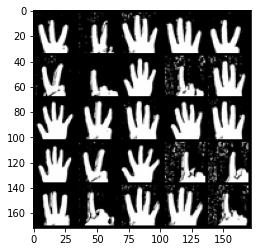

Epoch 37:   Accuracy = 0.8593750000000001%   Generator Loss = 2.9771048378944376   Discriminator Loss = 0.14561537139117722


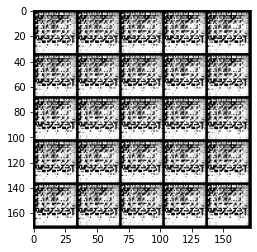

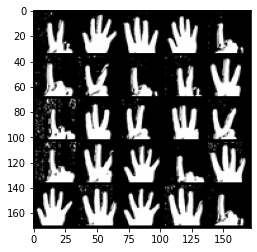

Epoch 50:   Accuracy = 1.953125%   Generator Loss = 3.0654440665245057   Discriminator Loss = 0.25426089778542516


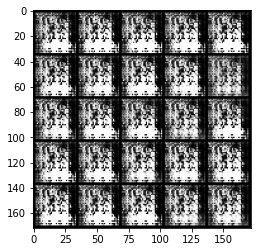

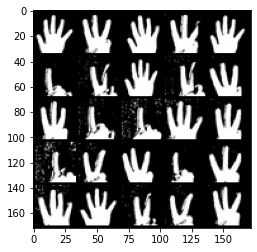

Epoch 62:   Accuracy = 12.421875%   Generator Loss = 2.5266022992134096   Discriminator Loss = 0.4266404800117017


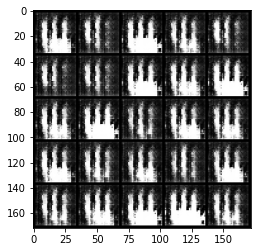

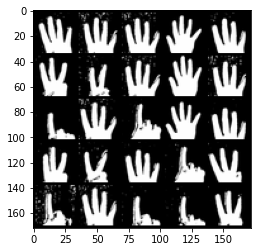

Epoch 75:   Accuracy = 8.203125%   Generator Loss = 2.7647999715805054   Discriminator Loss = 0.29129852123558525


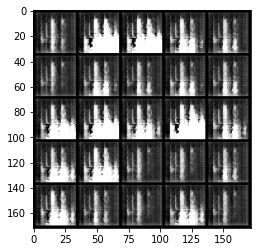

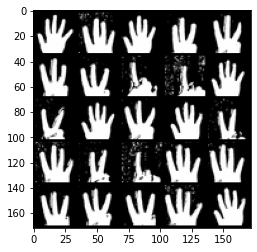

Epoch 87:   Accuracy = 12.65625%   Generator Loss = 2.2275680756568907   Discriminator Loss = 0.3611841033399106


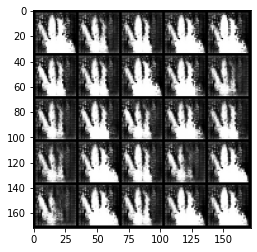

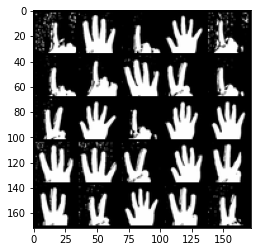

Epoch 100:   Accuracy = 14.0625%   Generator Loss = 2.1405945086479186   Discriminator Loss = 0.4512869009375572


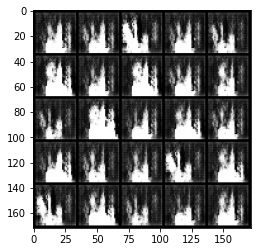

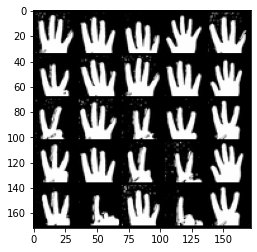

Epoch 112:   Accuracy = 19.453125%   Generator Loss = 1.4794871449470524   Discriminator Loss = 0.4733640471100809


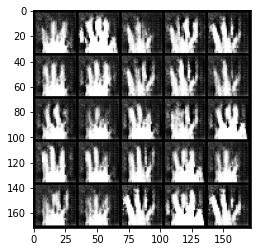

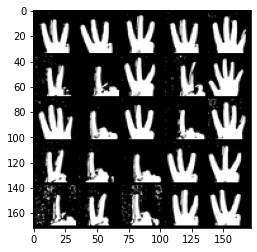

Epoch 125:   Accuracy = 24.21875%   Generator Loss = 1.0467554169893265   Discriminator Loss = 0.5511004120111465


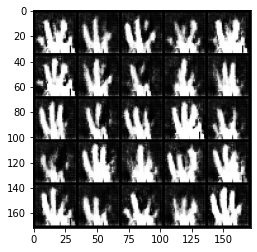

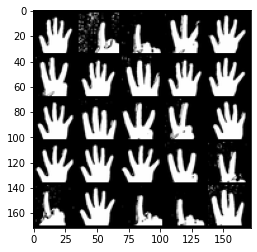

Epoch 137:   Accuracy = 23.828125%   Generator Loss = 0.9361639714241021   Discriminator Loss = 0.6022253060340882


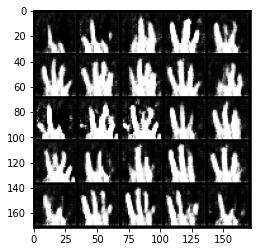

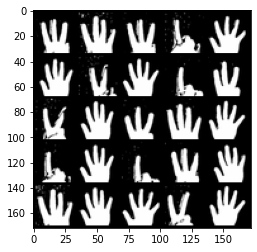

Epoch 150:   Accuracy = 33.984375%   Generator Loss = 0.8981210637092591   Discriminator Loss = 0.6242472684383391


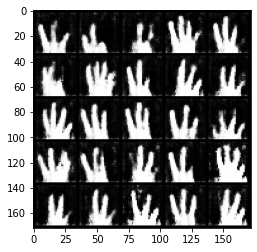

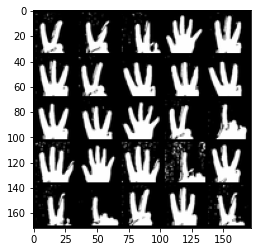

Epoch 162:   Accuracy = 36.71875%   Generator Loss = 0.8752582663297652   Discriminator Loss = 0.6370196837186812


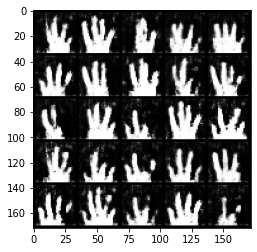

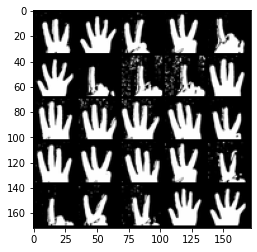

Epoch 175:   Accuracy = 26.5625%   Generator Loss = 0.8467640471458434   Discriminator Loss = 0.6492426949739455


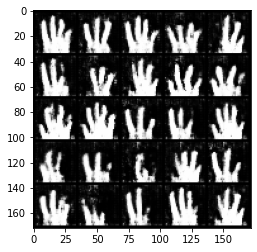

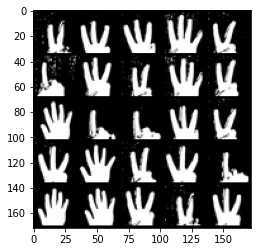

Epoch 187:   Accuracy = 37.5%   Generator Loss = 0.8283951449394226   Discriminator Loss = 0.6577040231227876


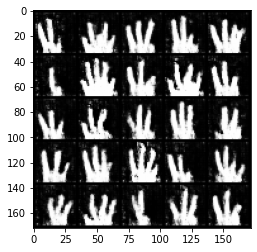

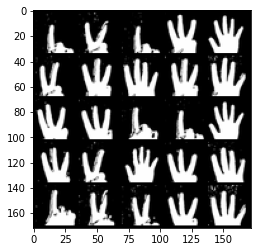

Epoch 200:   Accuracy = 33.984375%   Generator Loss = 0.8348563802242278   Discriminator Loss = 0.6578050982952116


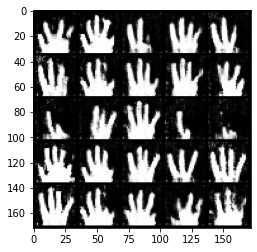

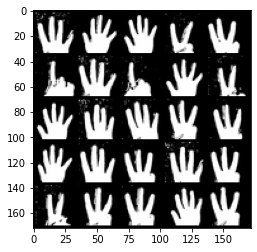

Epoch 212:   Accuracy = 38.75%   Generator Loss = 0.8191071945428849   Discriminator Loss = 0.6636406689882279


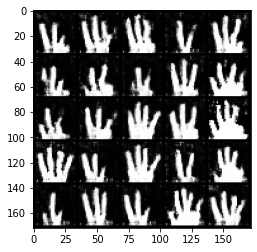

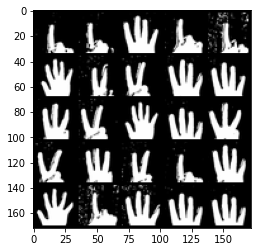

Epoch 225:   Accuracy = 65.625%   Generator Loss = 0.7998328530788419   Discriminator Loss = 0.6654594254493713


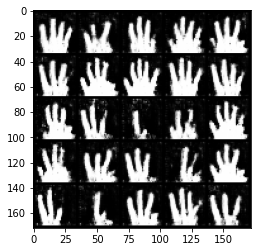

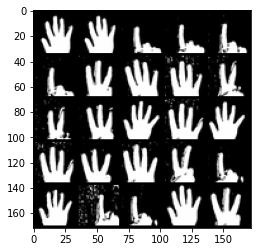

Epoch 237:   Accuracy = 38.359375%   Generator Loss = 0.8013344126939773   Discriminator Loss = 0.665799471735954


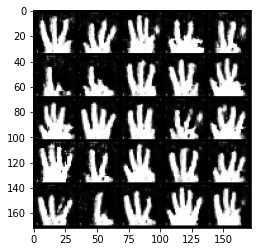

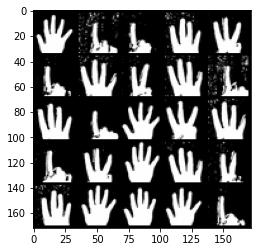

Epoch 250:   Accuracy = 30.46875%   Generator Loss = 0.7953846108913419   Discriminator Loss = 0.6666289591789246


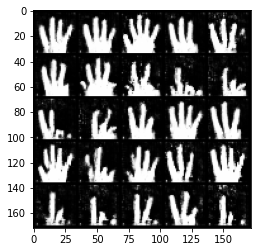

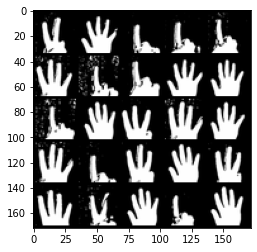

Epoch 262:   Accuracy = 36.484375%   Generator Loss = 0.7864295631647107   Discriminator Loss = 0.6710527193546293


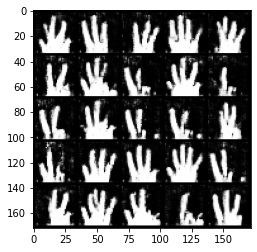

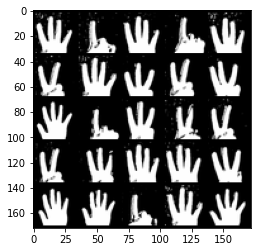

Epoch 275:   Accuracy = 27.34375%   Generator Loss = 0.8000043624639516   Discriminator Loss = 0.674577445983887


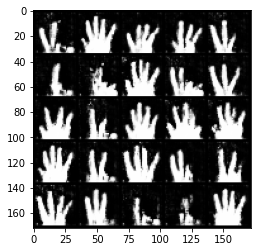

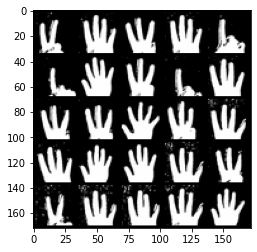

Epoch 287:   Accuracy = 45.234375%   Generator Loss = 0.7892652374505996   Discriminator Loss = 0.6715391308069234


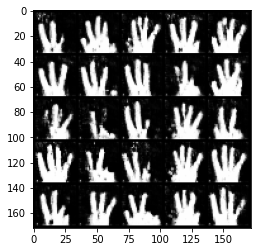

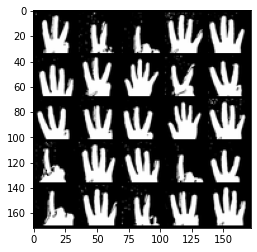

In [10]:
epoch_num, epoch_cur = 300, 0
G_mean_loss, D_mean_loss = 0, 0
G_Losses, D_Losses, Accuracy = [], [], []

for epoch in range(epoch_num):
  G_Loss, D_Loss, Acc = [], [], []
    
    for real, _ in (dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        # Updating discriminator
        D_optimizer.zero_grad()
        fake_noise = get_noise(cur_batch_size, 100, device=device).unsqueeze(2).unsqueeze(3)
        fake = G(fake_noise)

        disc_fake_pred = D(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))

        disc_real_pred = D(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))

        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        D_mean_loss += disc_loss.item() / 100

        disc_loss.backward(retain_graph=True)
        D_optimizer.step()

        # Updating generator
        G_optimizer.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, 100, device=device)
        fake_noise_2=fake_noise_2.unsqueeze(2)
        fake_noise_2=fake_noise_2.unsqueeze(3)
        fake_2 = G(fake_noise_2)

        disc_fake_pred = D(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))

        gen_loss.backward()
        G_optimizer.step()

        G_mean_loss += gen_loss.item() / 133

        G_Loss.append(G_mean_loss) 
        D_Loss.append(D_mean_loss) 

        acc = Accuracy(disc_fake_pred, torch.ones_like(disc_fake_pred)) + Accuracy(disc_real_pred, torch.zeros_like(disc_fake_pred))
        acc = acc / 2
        Acc.append(acc.item())

        if epoch_cur % 100 == 0 and epoch_cur > 0:
            print(f"Epoch {epoch}:   Accuracy = {sum(Acc) / len(Acc)*100}%   Generator Loss = {mean_generator_loss}   Discriminator Loss = {mean_discriminator_loss}")
            plot_image(fake)
            plot_image(real)
            G_mean_loss = 0
            D_mean_loss = 0
        epoch_cur += 1

    Accuracy.append(sum(Acc) / len(Acc))
    G_Losses.append(sum(G_Loss) / len(G_Loss))
    D_Losses.append(sum(D_Loss) / len(D_Loss))

Plot Generation and Discriminator Loss

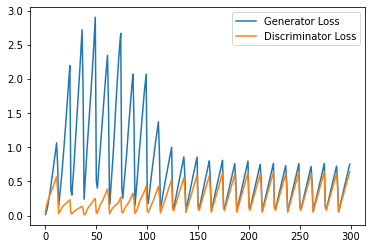

In [11]:
plt.plot(gen_loss_epoch, label='Generator Loss')
plt.plot(disc_loss_epoch, label='Discriminator Loss')
plt.legend()
plt.show()

Plot Discriminator Accuracy

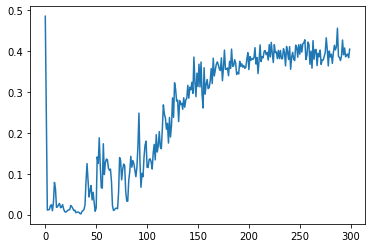

In [12]:
plt.plot(Acc, label='Accuracy')

Train Stabilization Model

Epoch 12:   Accuracy = 44.6875%   Generator Loss = 0.8962098789215084   Discriminator Loss = 0.6770395368337631


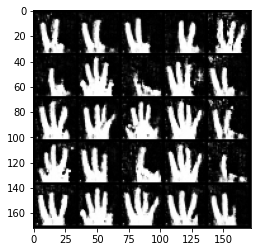

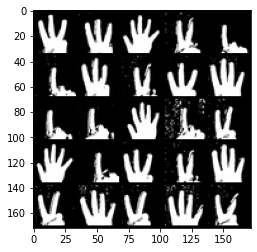

Epoch 25:   Accuracy = 32.421875%   Generator Loss = 0.8928079503774644   Discriminator Loss = 0.6740012824535367


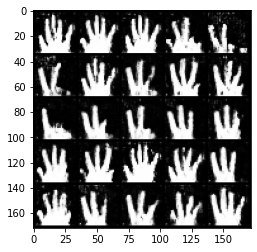

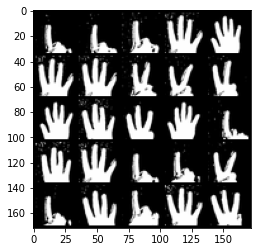

Epoch 37:   Accuracy = 43.359375%   Generator Loss = 0.8844942611455917   Discriminator Loss = 0.6736454474925998


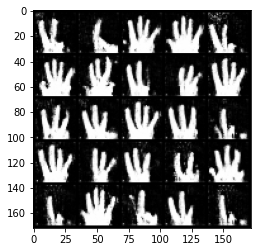

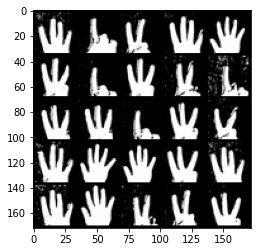

Epoch 50:   Accuracy = 35.546875%   Generator Loss = 0.8848923963308334   Discriminator Loss = 0.6764368301630015


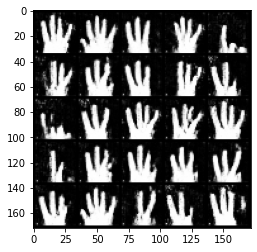

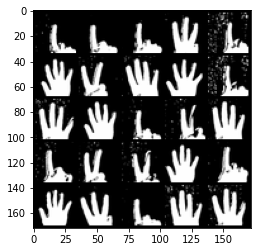

Epoch 62:   Accuracy = 43.984375%   Generator Loss = 0.8876116502285005   Discriminator Loss = 0.6780144774913784


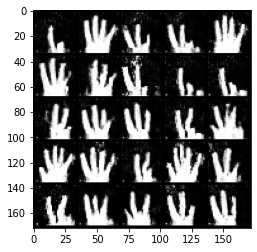

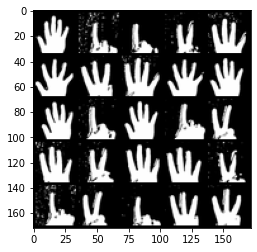

Epoch 75:   Accuracy = 52.734375%   Generator Loss = 0.8894073379039761   Discriminator Loss = 0.6764659404754637


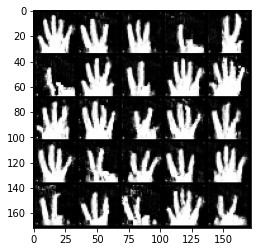

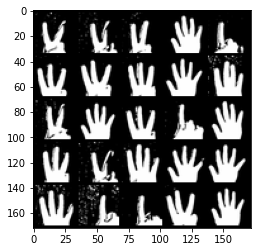

Epoch 87:   Accuracy = 42.65625%   Generator Loss = 0.880433264374733   Discriminator Loss = 0.6742766785621643


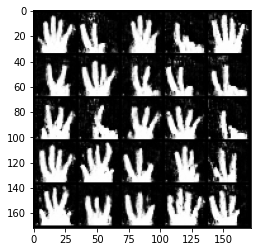

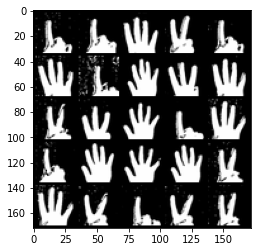

Epoch 100:   Accuracy = 28.125%   Generator Loss = 0.8764602917432784   Discriminator Loss = 0.6786247074604035


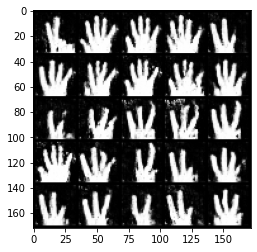

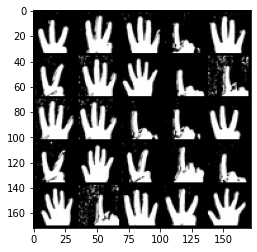

Epoch 112:   Accuracy = 41.71875%   Generator Loss = 0.8720770269632337   Discriminator Loss = 0.6794973552227019


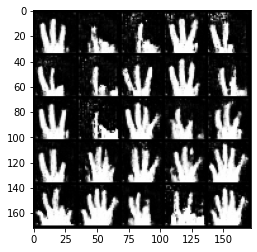

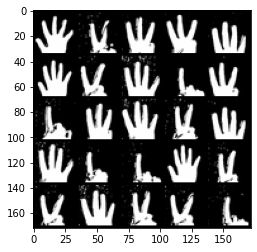

Epoch 125:   Accuracy = 51.171875%   Generator Loss = 0.8649357736110689   Discriminator Loss = 0.6807700717449192


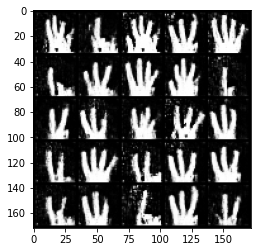

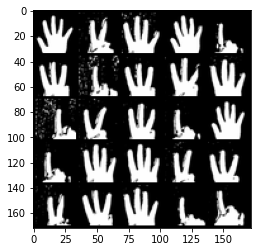

Epoch 137:   Accuracy = 45.15625%   Generator Loss = 0.8746561956405638   Discriminator Loss = 0.6820978796482087


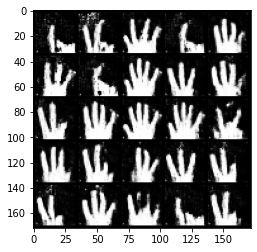

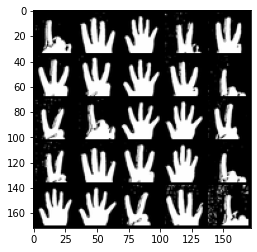

Epoch 150:   Accuracy = 30.46875%   Generator Loss = 0.8666264230012896   Discriminator Loss = 0.6815983408689501


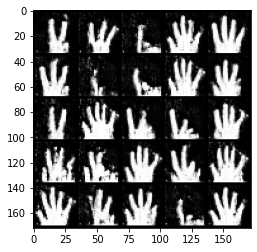

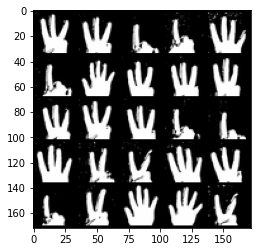

Epoch 162:   Accuracy = 46.875%   Generator Loss = 0.8624239820241923   Discriminator Loss = 0.6822828119993207


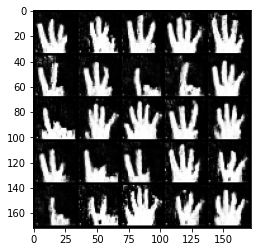

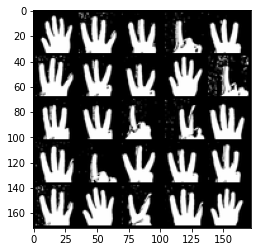

Epoch 175:   Accuracy = 43.75%   Generator Loss = 0.8636479908227924   Discriminator Loss = 0.6827735912799837


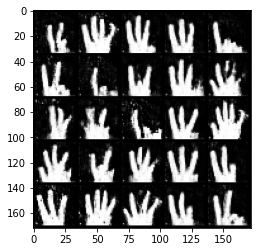

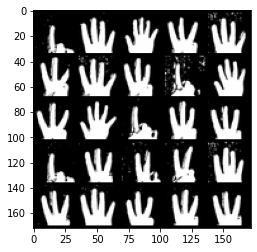

Epoch 187:   Accuracy = 42.1875%   Generator Loss = 0.859991301894188   Discriminator Loss = 0.6819787997007373


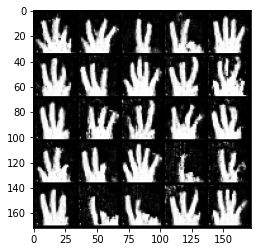

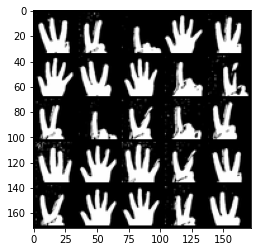

Epoch 200:   Accuracy = 50.78125%   Generator Loss = 0.8564204555749895   Discriminator Loss = 0.686552776098251


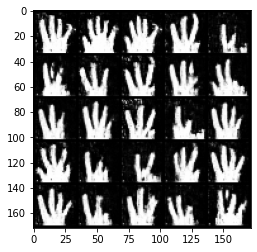

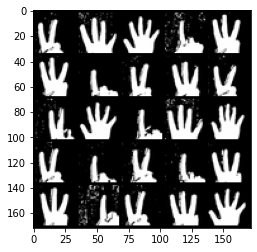

Epoch 212:   Accuracy = 45.3125%   Generator Loss = 0.8624623131752017   Discriminator Loss = 0.6840195059776305


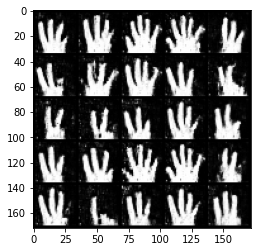

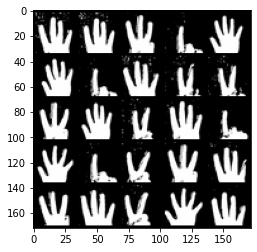

Epoch 225:   Accuracy = 40.625%   Generator Loss = 0.8585698491334914   Discriminator Loss = 0.6826408165693287


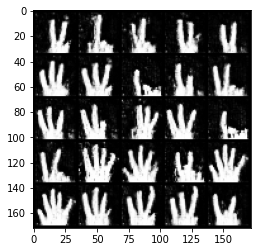

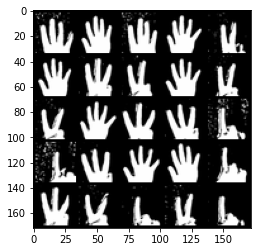

Epoch 237:   Accuracy = 44.453125%   Generator Loss = 0.8549254822731017   Discriminator Loss = 0.6840122520923614


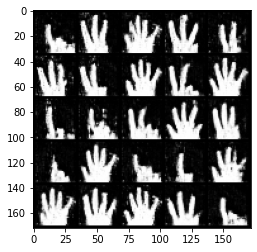

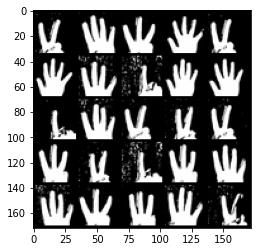

Epoch 250:   Accuracy = 48.4375%   Generator Loss = 0.8552154088020325   Discriminator Loss = 0.6846449327468871


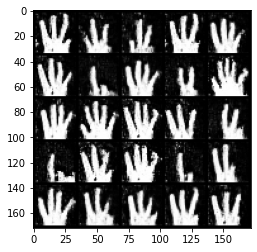

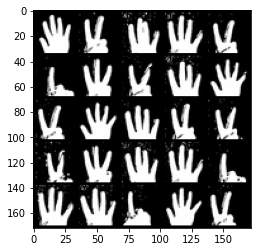

Epoch 262:   Accuracy = 43.984375%   Generator Loss = 0.8574574083089826   Discriminator Loss = 0.6870534002780915


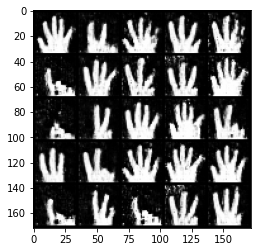

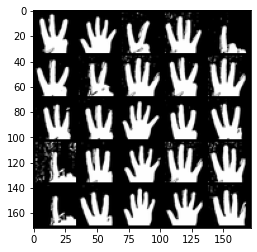

Epoch 275:   Accuracy = 49.609375%   Generator Loss = 0.8514368510246275   Discriminator Loss = 0.6846422588825227


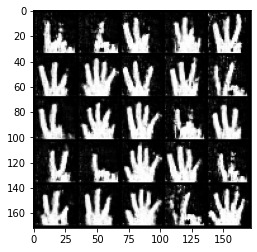

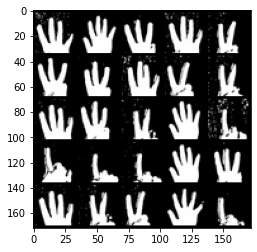

Epoch 287:   Accuracy = 48.046875%   Generator Loss = 0.8590369021892547   Discriminator Loss = 0.6854806542396545


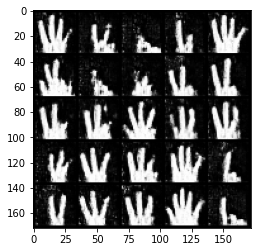

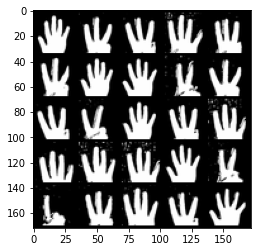

In [13]:
epoch_num, epoch_cur = 300, 0
G_mean_loss, D_mean_loss = 0, 0
G_Losses, D_Losses, Accuracy = [], [], []

for epoch in range(epoch_num):
    G_Loss, D_Loss, Acc = [], [], []

    for real, _ in (dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        # Updating discriminator
        D_optimizer.zero_grad()
        fake_noise = get_noise(cur_batch_size, 100, device=device)
        fake = G(fake_noise)
        # Add noise
        fake = fake + (0.01**1)*torch.randn(len(real), 32, 32).unsqueeze(1).to(device)

        disc_fake_pred = D(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))

        disc_real_pred = D(real)
        #label smoothing
        disc_real_loss = criterion(disc_real_pred, 0.9*torch.ones_like(disc_real_pred))

        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        mean_discriminator_loss += disc_loss.item() / 100

        disc_loss.backward(retain_graph=True)
        D_optimizer.step()

        # Updating generator
        G_optimizer.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, 100, device=device).unsqueeze(2).unsqueeze(3)
        fake_2 = G(fake_noise_2)

        disc_fake_pred = D(fake_2)
        G_Loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))

        G_Loss.backward()
        G_optimizer.step()

        mean_generator_loss += G_Loss.item() / 100

        gen_lss.append(mean_generator_loss) 
        disc_lss.append(mean_discriminator_loss) 

        acc = Accuracy(disc_fake_pred, torch.ones_like(disc_fake_pred)) + Accuracy(disc_real_pred, torch.zeros_like(disc_fake_pred))
        acc = acc / 2
        Acc.append(acc.item())

        if cur_step % 100 == 0 and cur_step > 0:
            print(f"Epoch {epoch}:   Accuracy = {sum(Acc) / len(Acc)*100}%   Generator Loss = {mean_generator_loss}   Discriminator Loss = {mean_discriminator_loss}")
            plot_image(fake)
            plot_image(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

    Acc_epoch.append(sum(Acc) / len(Acc))
    gen_loss_epoch.append(sum(G_Loss) / len(G_Loss))
    disc_loss_epoch.append(sum(D_Loss) / len(D_Loss))

Plot Generation and Discriminator Loss for Stabilization Network

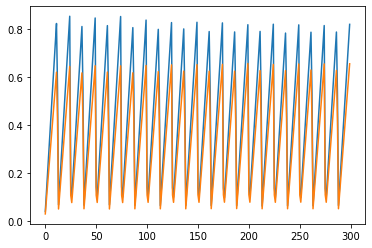

In [14]:
plt.plot(gen_loss_epoch, label='Generator Loss')
plt.plot(disc_loss_epoch, label='Discriminator Loss')

Plot Discriminator Accuracy for Stabilization Network

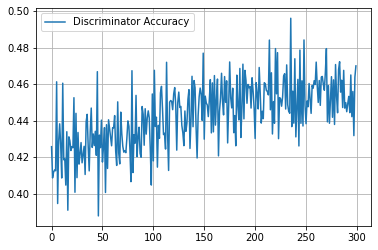

In [15]:
plt.plot(Acc, label='Discriminator Accuracy')
plt.legend()
plt.grid()
plt.show()